# Introduction

This tutorial uses data from [__AirBnB's 2015 recruiting competition on Kaggle.com__](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings) to demo the following tools:

- [__`Pandas`__](http://pandas.pydata.org), a `Python` tool for creating and manipulating SQL-like tabular data through __data frames__, inspired by `R`'s `data.frame` and `data.table` packages;

- [__`PySpark DataFrame`__ & __`PySpark SQL`__](http://spark.apache.org/docs/latest/sql-programming-guide.html), data-frame and SQL features shipped as part of large-scale distributed in-memory computing solution [__`Apache Spark`__](http://spark.apache.org) and well-integrated with `Pandas`.


To enable faster data import and demonstrating SQL-related capabilities, the `.CSV` data files provided on Kaggle have been uploaded to a `PostgreSQL` database hosted on Amazon Web Services (AWS) Relational Database Service (RDS) under Chicago Booth Analytics's account.

We will also showcase 2 visualization packages that are particularly well-integrated with data frames, namely __`GGplot`__ and __`Seaborn`__, which are higher-level wrappers around `Python`'s default visualization package `MatPlotLib`, although visualization is not the focus of this tutorial and will be covered more extensively in other tutorials.

# _\*\*\* Note on Technical Dependencies \*\*\*_

This tutorial requires the following software, assuming you are running on your personal computer:

- __`Anaconda Python` v2.7__ distribution;
    - You may follow the [__`Anaconda Python` installation guide__ on the Booth Analytics wiki]();
<br><br>

- __`SQLalchemy`__ Python package _(should already be included in `Anaconda Python` distribution)_;
<br><br>

- __`psycopy2`__ Python package, a driver for interacting with `PostgreSQL` though Python;
    - if your operating system is __Mac__, this should already be included in `Anaconda Python` distribution;
    - if your operating system is __Windows__, you can download and install the package from [__here__](http://www.lfd.uci.edu/~gohlke/pythonlibs/#psycopg); do select the correct version for `Python` v2.7 and for your processor (32-bit / 64-bit); <br><br>

- __`Apache Spark` v1.5.2 or later__, pre-built for Hadoop 2.6 or later _(go to [`Spark` download page](http://spark.apache.org/downloads.html) and you'll see something like that)_, downloaded and unpacked into a folder on your computer (_e.g._, `/Applications/spark-1.5.2` in my case);
    - Please do check out [__`Spark` installation guide__ on the Booth Analytics wiki](https://github.com/ChicagoBoothAnalytics/site/wiki/Apache-Spark-Installation) for important notes on setting environment variables;
<br><br>
    
- __`FindSpark`__ Python package, a useful utility to help load up the `PySpark` API in `Python`;
    - Install it simply by running command __`pip install --upgrade FindSpark`__ in your command-line terminal.
<br><br>

- __`GGplot`__ Python package for visualization;
    - Install by running command __`pip install --upgrade GGplot`__ in your command-line terminal;
<br><br>

- __`Seaborn`__ Python package for visualization;
    - Install by running command __`conda install Seaborn`__ in your command-line terminal.

# Import Python modules

In [91]:
from __future__ import print_function
import datetime
import os
import pandas
from pprint import pprint
import sys

In [95]:
# enable in-line plotting
%matplotlib inline

# import visualization packages
import matplotlib
import ggplot
import seaborn

In [2]:
# hack for live printing in iPython Notebook, adapted from:
# http://stackoverflow.com/questions/29772158/make-ipython-notebook-print-in-real-time
class flushfile():
    def __init__(self, f):
        self.f = f
    def __getattr__(self,name): 
        return object.__getattribute__(self.f, name)
    def write(self, x):
        self.f.write(x)
        self.f.flush()
    def flush(self):
        self.f.flush()
        
oldsysstdout = sys.stdout        
sys.stdout = flushfile(sys.stdout)

# Set _CONSTANTS_

In [3]:
# detect if running on Amazon Web Services (AWS) Elastic MapReduce (EMR)
# NOTE: the following line's method is specific to how ChicagoBoothML sets up AWS EMR clusters;
# in your own case, if you use AWS EMR, please come up with your own way of telling
AWS_EMR_MODE = os.path.expanduser('~').startswith('/mnt')

# set Apache Spark-related constants, depending on AWS_EMR_MODE
if AWS_EMR_MODE:                               # if running Spark on AWS Elastic MapReduce (EMR) YARN cluster
    SPARK_MODE = 'yarn-client'
    SPARK_HOME = '/usr/lib/spark'              # default Spark installation folder on AWS EMR master node
else:                                          # if running Spark on single machine
    SPARK_MODE = 'local'
    SPARK_HOME = 'C:/Programs/spark-1.5.2'   # Spark installation folder on my machine; *** CHANGE TO SUIT YOURS ***
                                               # e.g., '/Applications/spark-1.5.2', 'C:/Programs/spark-1.5.2'

# Kaggle AirBnB database specs
DB_ENGINE = 'postgresql'                                                 # this is a PostgreSQL database on AWS RDS
DB_HOST_URL = 'kaggle-airbnb.clloyfrn47sj.us-west-1.rds.amazonaws.com'   # database's host server URL
DB_PORT = 5432                                                           # default port for PostgreSQL
DB_NAME = 'Kaggle_AirBnB'                                                # database's name
DB_USER_NAME = 'BoothAnalytics'                                          # database's master username
DB_PASSWORD = 'password'                                                 # database's master password
DB_ACCESS_URL = '%s://%s:%i/%s?user=%s&password=%s' \
    % (DB_ENGINE, DB_HOST_URL, DB_PORT, DB_NAME, DB_USER_NAME, DB_PASSWORD)
JDBC_DB_ACCESS_URL = 'jdbc:%s' % DB_ACCESS_URL 

# local .CSV data files
LOCAL_DATA_FOLDER_PATH = '../data'
USERS_DATA_FILE_NAME = 'train_users_2.csv'
COUNTRIES_DATA_FILE_NAME = 'countries.csv'
AGE_GENDER_DESTINATION_STATS_FILE_NAME = 'age_gender_bkts.csv'
USERS_DATA_FILE_PATH = \
    os.path.join(
        LOCAL_DATA_FOLDER_PATH,
        USERS_DATA_FILE_NAME)\
    .replace('\\', '/')
COUNTRIES_DATA_FILE_PATH = \
    os.path.join(
        LOCAL_DATA_FOLDER_PATH,
        COUNTRIES_DATA_FILE_NAME)\
    .replace('\\', '/')
AGE_GENDER_DESTINATION_STATS_FILE_PATH = \
    os.path.join(
        LOCAL_DATA_FOLDER_PATH,
        AGE_GENDER_DESTINATION_STATS_FILE_NAME)\
    .replace('\\', '/')

# GitHub repo raw path
# GITHUB_REPO_RAW_PATH = 'https://raw.githubusercontent.com/ChicagoBoothAnalytics/RelationalData/master'
# SQL_JDBC_DRIVERS_FOLDER_NAME = 'SQL-JDBC-Drivers'
# POSTGRESQL_JDBC_DRIVER_FILE_NAME = 'PostgreSQL-JDBC42-9.4.1207.jar'
# POSTGRESQL_JDBC_DRIVER_URL = \
#     os.path.join(
#         GITHUB_REPO_RAW_PATH,
#         SQL_JDBC_DRIVERS_FOLDER_NAME,
#         POSTGRESQL_JDBC_DRIVER_FILE_NAME)\
#     .replace('\\', '/')

# number of examples to show from a data set   
NB_EXAMPLES_TO_SHOW = 30

# Set up `SparkContext` & `SQLContext`

In [4]:
if 'pyspark' not in vars():
    
    # set / clean up environment variables for Spark
    os.environ['SPARK_HOME'] = SPARK_HOME
    print("Removing any existing 'SPARK_CLASSPATH' environment variable: ", end='')
    spark_classpath = os.environ.pop('SPARK_CLASSPATH', None)
    if spark_classpath:
        print("'%s', done!\n" % spark_classpath)
    else:
        print('done!\n')
    
    # import FindSpark to enable importing of PySpark
    import findspark
    findspark.init()
    
    # import PySpark and set up SparkContext & HiveContext
    import pyspark
    
    sc = pyspark.SparkContext(
        conf=pyspark.SparkConf()
            .setMaster(SPARK_MODE)
            .setAppName('KaggleAirBnB'))
    sc_confs_df = \
        pandas.DataFrame(
            data=sc._conf.getAll(),
            columns=['key', 'value'])\
        .sort_values(by='key')
    
    sqlc = pyspark.sql.SQLContext(sc)
    
print('SparkContext: %s\n' % str(sc))
print('SQLContext: %s\n' % str(sqlc))
print('Detailed (Non-Default) SparkContext Configurations:')
sc_confs_df

Removing any existing 'SPARK_CLASSPATH' environment variable: 'C:/Programs/PostgreSQL/9.4/postgresql-9.4-1205.jdbc42.jar', done!

SparkContext: <pyspark.context.SparkContext object at 0x000000001D29CE80>

SQLContext: <pyspark.sql.context.SQLContext object at 0x000000001D36BC50>

Detailed (Non-Default) SparkContext Configurations:


,key,value
9,spark.app.name,KaggleAirBnB
3,spark.driver.extraClassPath,C:/Repos/MBALearnsToCode/RelationalData/SQL-JD...
7,spark.driver.maxResultSize,3g
2,spark.driver.memory,6g
8,spark.executor.extraClassPath,C:/Repos/MBALearnsToCode/RelationalData/SQL-JD...
1,spark.executor.memory,2g
0,spark.master,local
4,spark.rdd.compress,True
5,spark.serializer.objectStreamReset,100
6,spark.submit.deployMode,client


# Import additional modules / classes / functions from `PySpark`

In [5]:
from pyspark.files import SparkFiles

# Download & import __`PySpark_CSV.py`__ utility

In [20]:
!curl https://raw.githubusercontent.com/seahboonsiew/pyspark-csv/master/pyspark_csv.py --output pyspark_csv.py

if AWS_EMR_MODE:
    sc.addPyFile('pyspark_csv.py')

from pyspark_csv import csvToDataFrame

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  5493  100  5493    0     0   4882      0  0:00:01  0:00:01 --:--:--  4882


# Read Kaggle AirBnB Data

## __`users`__ table

### ___`Pandas`___

In [25]:
print("Reading 'users[_train]' database table into Pandas DataFrame... ", end='')
tic = datetime.datetime.now()

users_df = \
    pandas.read_sql_table(
        table_name='users_train',   # Name of SQL table in database
        con=DB_ACCESS_URL,          # SQLAlchemy connectable (or database string URI)
        schema=None,                # Name of SQL schema in database to query; If None, use default schema (default).
        index_col=None,             # Column(s) to set as index(MultiIndex); string or list of strings
        coerce_float=True,          # Convert non-string, non-numeric objects (like decimal.Decimal) to floating point
        parse_dates=None,           # List of column names to parse as dates
        columns=None,               # List of column names to select from sql table; if None, select all
    )

toc = datetime.datetime.now()
print('done after %s\n' % str(toc-tic))
    
print("'users' table (Pandas DataFrame):\n")
users_df.info()

print('\nShowing first %i rows:' % NB_EXAMPLES_TO_SHOW)
users_df.iloc[:NB_EXAMPLES_TO_SHOW]

Reading 'users[_train]' database table into Pandas DataFrame... done after 0:00:18.244000

'users' table (Pandas DataFrame):

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null datetime64[ns]
timestamp_first_active     213451 non-null object
date_first_booking         88908 non-null datetime64[ns]
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null objec

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaT,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
5,osr2jwljor,2010-01-01,20100101215619,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
7,0d01nltbrs,2010-01-03,20100103191905,2010-01-13,FEMALE,47,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US
8,a1vcnhxeij,2010-01-04,20100104004211,2010-07-29,FEMALE,50,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
9,6uh8zyj2gn,2010-01-04,20100104023758,2010-01-04,-unknown-,46,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US


We can alternatively read from a local `.CSV` file:

In [26]:
print("Reading '%s' file into Pandas DataFrame... " % USERS_DATA_FILE_NAME, end='')
tic = datetime.datetime.now()

users_df_from_csv = pandas.read_csv(USERS_DATA_FILE_PATH)

toc = datetime.datetime.now()
print('done after %s\n' % str(toc - tic))

print("'users' table (Pandas DataFrame):\n")
users_df_from_csv.info()

print('\nShowing first %i rows:' % NB_EXAMPLES_TO_SHOW)
users_df_from_csv.iloc[:NB_EXAMPLES_TO_SHOW]

Reading 'train_users_2.csv' file into Pandas DataFrame... done after 0:00:00.551000

'users' table (Pandas DataFrame):

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination  

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
5,osr2jwljor,2010-01-01,20100101215619,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
7,0d01nltbrs,2010-01-03,20100103191905,2010-01-13,FEMALE,47,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US
8,a1vcnhxeij,2010-01-04,20100104004211,2010-07-29,FEMALE,50,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
9,6uh8zyj2gn,2010-01-04,20100104023758,2010-01-04,-unknown-,46,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US


### ___`PySpark SQL`___

In [9]:
try:
    
    print("Reading 'users[_train]' database table into PySpark SQL Distributed DataFrame... ", end='')
    tic = datetime.datetime.now()

    users_ddf = \
        sqlc.read.load(
            format='jdbc',
            url=JDBC_DB_ACCESS_URL,
            dbtable='users_train')\
        .cache()    
    users_ddf.registerTempTable('users')

    print('done!\n')

    print("'users' table (PySpark SQL Distributed DataFrame):\n")
    users_ddf.printSchema()

    print('\nShowing first %i rows:' % NB_EXAMPLES_TO_SHOW)
    users_ddf.show(NB_EXAMPLES_TO_SHOW)

    toc = datetime.datetime.now()
    print('Time Taken:', toc - tic)
    
    users_spark_sql_read_success = True
    
except:
    
    users_spark_sql_read_success = False
    
    print('\n\nEncountered problem while reading SQL database from local Spark; falling back onto parsing local .CSV file...')

Reading 'users[_train]' database table into PySpark SQL Distributed DataFrame... done!

'users' table (PySpark SQL Distributed DataFrame):

root
 |-- id: string (nullable = true)
 |-- date_account_created: date (nullable = true)
 |-- timestamp_first_active: string (nullable = true)
 |-- date_first_booking: date (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)


Showing first 30 rows:
+----------+--------------------+----------------------+------------------+---------+----+-----------

We can also read from a local `.CSV` file:

In [24]:
# if running on AWS EMR YARN cluster, we need to copy the local .CSV file to the Hadoop File System:
if AWS_EMR_MODE:
    spark_data_file_path = USERS_DATA_FILE_NAME
    os.system('hadoop fs -put %s %s' % (USERS_DATA_FILE_PATH, spark_data_file_path))
else:
    spark_data_file_path = USERS_DATA_FILE_PATH

print("Reading '%s' into PySpark SQL Distributed DataFrame... "
      % USERS_DATA_FILE_NAME, end='')

users_ddf_from_csv = \
    csvToDataFrame(
        sqlCtx=sqlc,
        rdd=sc.textFile(spark_data_file_path),
        columns=None,
        sep=',',
        parseDate=True)

print('done!\n')
    
print("'users' table (PySpark SQL Distributed DataFrame):\n")
users_ddf_from_csv.printSchema()

print('\nShowing first %i rows:' % NB_EXAMPLES_TO_SHOW)
users_ddf_from_csv.show(NB_EXAMPLES_TO_SHOW)

toc = datetime.datetime.now()
print('Time Taken:', toc - tic)

if not users_spark_sql_read_success:
    users_ddf = users_df_from_csv
    users_ddf.cache()
    users_ddf.registerTempTable('users')

Reading 'train_users_2.csv' into PySpark SQL Distributed DataFrame... 

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 16.0 failed 1 times, most recent failure: Lost task 0.0 in stage 16.0 (TID 16, localhost): java.net.SocketException: Connection reset by peer: socket write error
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(SocketOutputStream.java:109)
	at java.net.SocketOutputStream.write(SocketOutputStream.java:153)
	at java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:82)
	at java.io.BufferedOutputStream.write(BufferedOutputStream.java:126)
	at java.io.DataOutputStream.write(DataOutputStream.java:107)
	at java.io.FilterOutputStream.write(FilterOutputStream.java:97)
	at org.apache.spark.api.python.PythonRDD$.writeUTF(PythonRDD.scala:622)
	at org.apache.spark.api.python.PythonRDD$.org$apache$spark$api$python$PythonRDD$$write$1(PythonRDD.scala:442)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:452)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:452)
	at scala.collection.Iterator$class.foreach(Iterator.scala:727)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1157)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:452)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:280)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1699)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:239)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1283)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1271)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1270)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1270)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1496)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1458)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1447)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:567)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1824)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1837)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1850)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:393)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.net.SocketException: Connection reset by peer: socket write error
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(SocketOutputStream.java:109)
	at java.net.SocketOutputStream.write(SocketOutputStream.java:153)
	at java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:82)
	at java.io.BufferedOutputStream.write(BufferedOutputStream.java:126)
	at java.io.DataOutputStream.write(DataOutputStream.java:107)
	at java.io.FilterOutputStream.write(FilterOutputStream.java:97)
	at org.apache.spark.api.python.PythonRDD$.writeUTF(PythonRDD.scala:622)
	at org.apache.spark.api.python.PythonRDD$.org$apache$spark$api$python$PythonRDD$$write$1(PythonRDD.scala:442)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:452)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:452)
	at scala.collection.Iterator$class.foreach(Iterator.scala:727)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1157)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:452)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:280)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1699)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:239)


## __`countries`__ table

### ___`Pandas`___

In [12]:
print("Reading 'countries' table into Pandas DataFrame... ", end='')
tic = datetime.datetime.now()

countries_df = \
    pandas.read_sql_table(
        table_name='countries',   # Name of SQL table in database
        con=DB_ACCESS_URL,        # SQLAlchemy connectable (or database string URI)
        schema=None,              # Name of SQL schema in database to query; If None, use default schema (default).
        index_col=None,           # Column(s) to set as index(MultiIndex); string or list of strings
        coerce_float=True,        # Convert non-string, non-numeric objects (like decimal.Decimal) to floating point
        parse_dates=None,         # List of column names to parse as dates
        columns=None,             # List of column names to select from sql table; if None, select all
    )

toc = datetime.datetime.now()
print('done after %s\n' % str(toc-tic))
    
print("'countries' table (Pandas DataFrame):\n")
countries_df.info()
countries_df

Reading 'countries' table into Pandas DataFrame... done after 0:00:02.560000

'countries' table (Pandas DataFrame):

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 7 columns):
country_destination              10 non-null object
lat_destination                  10 non-null float64
lng_destination                  10 non-null float64
distance_km                      10 non-null float64
destination_km2                  10 non-null float64
destination_language             10 non-null object
language_levenshtein_distance    10 non-null float64
dtypes: float64(5), object(2)
memory usage: 640.0+ bytes


,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675,eng,0.00


Alternative reading from local `.CSV` file:

In [27]:
print("Reading '%s' file into Pandas DataFrame... " % COUNTRIES_DATA_FILE_NAME, end='')
tic = datetime.datetime.now()

countries_df_from_csv = pandas.read_csv(COUNTRIES_DATA_FILE_PATH)

toc = datetime.datetime.now()
print('done after %s\n' % str(toc - tic))

print("'countries' table (Pandas DataFrame):\n")
countries_df_from_csv.info()
countries_df_from_csv

Reading 'countries.csv' file into Pandas DataFrame... done after 0:00:00.025000

'countries' table (Pandas DataFrame):

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 7 columns):
country_destination              10 non-null object
lat_destination                  10 non-null float64
lng_destination                  10 non-null float64
distance_km                      10 non-null float64
destination_km2                  10 non-null float64
destination_language             10 non-null object
language_levenshtein_distance    10 non-null float64
dtypes: float64(5), object(2)
memory usage: 640.0+ bytes


,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675,eng,0.00


### ___`PySpark SQL`___

In [23]:
try:
    
    print("Reading 'countries' table into PySpark SQL Distributed DataFrame... ", end='')
    tic = datetime.datetime.now()

    countries_ddf = \
        sqlc.read.load(
            format='jdbc',
            url=JDBC_DB_ACCESS_URL,
            dbtable='countries')\
        .cache()
    countries_ddf.registerTempTable('countries')

    print('done!\n')

    print("'coutnries' table (Spark SQL Distributed Data Frame):\n")
    countries_ddf.printSchema()
    countries_ddf.show()

    toc = datetime.datetime.now()
    print('Time Taken:', toc - tic)
    
    countries_spark_sql_read_success = True
    
except:
    
    countries_spark_sql_read_success = False
    
    print('\n\nEncountered problem while reading SQL database from local Spark; falling back onto parsing local .CSV file...')

Reading 'countries' table into PySpark SQL Distributed DataFrame... done!

'coutnries' table (Spark SQL Distributed Data Frame):

root
 |-- country_destination: string (nullable = true)
 |-- lat_destination: double (nullable = true)
 |-- lng_destination: double (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- destination_km2: double (nullable = true)
 |-- destination_language: string (nullable = true)
 |-- language_levenshtein_distance: double (nullable = true)

+-------------------+---------------+---------------+-----------+---------------+--------------------+-----------------------------+
|country_destination|lat_destination|lng_destination|distance_km|destination_km2|destination_language|language_levenshtein_distance|
+-------------------+---------------+---------------+-----------+---------------+--------------------+-----------------------------+
|                 AU|     -26.853388|      133.27516|  15297.744|      7741220.0|                 eng|               

In [15]:
# if running on AWS EMR YARN cluster, we need to copy the local .CSV file to the Hadoop File System:
if AWS_EMR_MODE:
    spark_data_file_path = COUNTRIES_DATA_FILE_NAME
    os.system('hadoop fs -put %s %s' % (COUNTRIES_DATA_FILE_PATH, spark_data_file_path))
else:
    spark_data_file_path = COUNTRIES_DATA_FILE_PATH

print("Reading '%s' into PySpark SQL Distributed DataFrame... "
      % COUNTRIES_DATA_FILE_NAME, end='')

countries_ddf_from_csv = \
    csvToDataFrame(
        sqlCtx=sqlc,
        rdd=sc.textFile(spark_data_file_path),
        columns=None,
        sep=',',
        parseDate=True)

print('done!\n')
    
print("'countries' table (PySpark SQL Distributed DataFrame):\n")
countries_ddf_from_csv.printSchema()

print('\nShowing first %i rows:' % NB_EXAMPLES_TO_SHOW)
countries_ddf_from_csv.show(NB_EXAMPLES_TO_SHOW)

toc = datetime.datetime.now()
print('Time Taken:', toc - tic)

if not countries_spark_sql_read_success:
    countries_ddf = countries_ddf_from_csv
    countries_ddf.cache()
    countries_ddf.registerTempTable('countries')

Reading 'countries.csv' into PySpark SQL Distributed DataFrame... done!

'countries' table (PySpark SQL Distributed DataFrame):

root
 |-- country_destination: string (nullable = true)
 |-- lat_destination: double (nullable = true)
 |-- lng_destination: double (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- destination_km2: integer (nullable = true)
 |-- destination_language : string (nullable = true)
 |-- language_levenshtein_distance: double (nullable = true)


Showing first 30 rows:
+-------------------+---------------+---------------+-----------+---------------+---------------------+-----------------------------+
|country_destination|lat_destination|lng_destination|distance_km|destination_km2|destination_language |language_levenshtein_distance|
+-------------------+---------------+---------------+-----------+---------------+---------------------+-----------------------------+
|                 AU|     -26.853388|      133.27516|  15297.744|        7741220|        

## __`age_gender_destination_stats`__ table

### ___`Pandas`___

In [28]:
print("Reading 'age_gender_destination_stats' database table into Pandas DataFrame... ", end='')
tic = datetime.datetime.now()

age_gender_destination_stats_df = \
    pandas.read_sql_table(
        table_name='age_gender_destination_stats',   # Name of SQL table in database
        con=DB_ACCESS_URL,   # SQLAlchemy connectable (or database string URI)
        schema=None,         # Name of SQL schema in database to query; If None, use default schema (default).
        index_col=None,      # Column(s) to set as index(MultiIndex); string or list of strings
        coerce_float=True,   # Convert non-string, non-numeric objects (like decimal.Decimal) to floating point
        parse_dates=None,    # List of column names to parse as dates
        columns=None,        # List of column names to select from sql table; if None, select all
    )

toc = datetime.datetime.now()
print('done after %s\n' % str(toc-tic))
    
print("'age_gender_destination_stats' table (Pandas DataFrame):\n")
age_gender_destination_stats_df.info()

print('\nShowing first %i rows:' % NB_EXAMPLES_TO_SHOW)
age_gender_destination_stats_df.iloc[:NB_EXAMPLES_TO_SHOW]

Reading 'age_gender_destination_stats' database table into Pandas DataFrame... done after 0:00:02.465000

'age_gender_destination_stats' table (Pandas DataFrame):

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 0 to 419
Data columns (total 5 columns):
age_bucket                 420 non-null object
country_destination        420 non-null object
gender                     420 non-null object
population_in_thousands    420 non-null float64
year                       420 non-null float64
dtypes: float64(2), object(3)
memory usage: 19.7+ KB

Showing first 30 rows:


,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1,2015
1,95-99,AU,male,9,2015
2,90-94,AU,male,47,2015
3,85-89,AU,male,118,2015
4,80-84,AU,male,199,2015
5,75-79,AU,male,298,2015
6,70-74,AU,male,415,2015
7,65-69,AU,male,574,2015
8,60-64,AU,male,636,2015
9,55-59,AU,male,714,2015


Alternative reading from local `.CSV` file:

In [29]:
print("Reading '%s' file into Pandas DataFrame... "
      % AGE_GENDER_DESTINATION_STATS_FILE_NAME, end='')
tic = datetime.datetime.now()

age_gender_destination_stats_df_from_csv = \
    pandas.read_csv(AGE_GENDER_DESTINATION_STATS_FILE_PATH)

toc = datetime.datetime.now()
print('done after %s\n' % str(toc - tic))

print("'age_gender_destination_stats' table (Pandas DataFrame):\n")
age_gender_destination_stats_df_from_csv.info()

print('\nShowing first %i rows:' % NB_EXAMPLES_TO_SHOW)
age_gender_destination_stats_df_from_csv.iloc[:NB_EXAMPLES_TO_SHOW]

Reading 'age_gender_bkts.csv' file into Pandas DataFrame... done after 0:00:00.047000

'age_gender_destination_stats' table (Pandas DataFrame):

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 0 to 419
Data columns (total 5 columns):
age_bucket                 420 non-null object
country_destination        420 non-null object
gender                     420 non-null object
population_in_thousands    420 non-null float64
year                       420 non-null float64
dtypes: float64(2), object(3)
memory usage: 19.7+ KB

Showing first 30 rows:


,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1,2015
1,95-99,AU,male,9,2015
2,90-94,AU,male,47,2015
3,85-89,AU,male,118,2015
4,80-84,AU,male,199,2015
5,75-79,AU,male,298,2015
6,70-74,AU,male,415,2015
7,65-69,AU,male,574,2015
8,60-64,AU,male,636,2015
9,55-59,AU,male,714,2015


### ___`PySpark SQL`___

In [18]:
try:

    print("Reading 'age_gender_destination_stats' database table into PySpark SQL Distributed DataFrame... ", end='')
    tic = datetime.datetime.now()

    age_gender_destination_stats_ddf = \
        sqlc.read.load(
            format='jdbc',
            url=JDBC_DB_ACCESS_URL,
            dbtable='age_gender_destination_stats')\
        .cache()
    age_gender_destination_stats_ddf.registerTempTable('age_gender_destination_stats')

    print('done!\n')
    
    print("'age_gender_destination_stats' table:\n")
    age_gender_destination_stats_ddf.printSchema()
    
    print('\nShowing first %i rows:' % NB_EXAMPLES_TO_SHOW)
    age_gender_destination_stats_ddf.show(NB_EXAMPLES_TO_SHOW)

    toc = datetime.datetime.now()
    print('Time Taken:', toc - tic)
    
    age_gender_destination_stats_spark_sql_read_success = True
    
except:
    
    age_gender_destination_stats_spark_sql_read_success = False
    
    print('\n\nEncountered problem while reading SQL database from local Spark; falling back onto parsing local .CSV file...')

Reading 'age_gender_destination_stats' database table into PySpark SQL Distributed DataFrame... done!

'age_gender_destination_stats' table:

root
 |-- age_bucket: string (nullable = true)
 |-- country_destination: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- population_in_thousands: double (nullable = true)
 |-- year: double (nullable = true)


Showing first 30 rows:
+----------+-------------------+------+-----------------------+------+
|age_bucket|country_destination|gender|population_in_thousands|  year|
+----------+-------------------+------+-----------------------+------+
|      100+|                 AU|  male|                    1.0|2015.0|
|     95-99|                 AU|  male|                    9.0|2015.0|
|     90-94|                 AU|  male|                   47.0|2015.0|
|     85-89|                 AU|  male|                  118.0|2015.0|
|     80-84|                 AU|  male|                  199.0|2015.0|
|     75-79|                 AU|  male

Alternative reading from local `.CSV` file:

In [19]:
# if running on AWS EMR YARN cluster, we need to copy the local .CSV file to the Hadoop File System:
if AWS_EMR_MODE:
    spark_data_file_path = AGE_GENDER_DESTINATION_STATS_FILE_NAME
    os.system('hadoop fs -put %s %s' % (AGE_GENDER_DESTINATION_STATS_FILE_PATH, spark_data_file_path))
else:
    spark_data_file_path = AGE_GENDER_DESTINATION_STATS_FILE_PATH

print("Reading '%s' into PySpark SQL Distributed DataFrame... "
      % AGE_GENDER_DESTINATION_STATS_FILE_NAME, end='')

age_gender_destination_stats_ddf_from_csv = \
    csvToDataFrame(
        sqlCtx=sqlc,
        rdd=sc.textFile(spark_data_file_path),
        columns=None,
        sep=',',
        parseDate=True)

print('done!\n')
    
print("'age_gender_destination_stats' table (PySpark SQL Distributed DataFrame):\n")
age_gender_destination_stats_ddf_from_csv.printSchema()

print('\nShowing first %i rows:' % NB_EXAMPLES_TO_SHOW)
age_gender_destination_stats_ddf_from_csv.show(NB_EXAMPLES_TO_SHOW)

toc = datetime.datetime.now()
print('Time Taken:', toc - tic)

if not age_gender_destination_stats_spark_sql_read_success:
    age_gender_destination_stats_ddf = age_gender_destination_stats_ddf_from_csv
    age_gender_destination_stats_ddf.cache()
    age_gender_destination_stats_ddf.registerTempTable('age_gender_destination_stats')

Reading 'age_gender_bkts.csv' into PySpark SQL Distributed DataFrame... done!

'age_gender_destination_stats' table (PySpark SQL Distributed DataFrame):

root
 |-- age_bucket: string (nullable = true)
 |-- country_destination: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- population_in_thousands: integer (nullable = true)
 |-- year: integer (nullable = true)


Showing first 30 rows:
+----------+-------------------+------+-----------------------+----+
|age_bucket|country_destination|gender|population_in_thousands|year|
+----------+-------------------+------+-----------------------+----+
|      100+|                 AU|  male|                      1|2015|
|     95-99|                 AU|  male|                      9|2015|
|     90-94|                 AU|  male|                     47|2015|
|     85-89|                 AU|  male|                    118|2015|
|     80-84|                 AU|  male|                    199|2015|
|     75-79|                 AU|  male| 

# Data Analyses & Visualizations

The rest of this iPython Notebook tutorial contains a series of exploratory data analyses highlighting the various __`Pandas`__ and __`PySpark SQL DataFrame`__ syntaxes.

Occasionally, we'll visualize certain results to enable intuitive understanding. Having said that, visualization is not a main goal of this tutorial and will be covered more extensively in another tutorial.

## Count number of rows of `age_gender_destination_stats` table

### ___`Pandas`___

Highlights:

- `len(<Pandas DataFrame>)`: count number of rows of `Pandas DataFrame`.

In [52]:
print("'age_gender_destination_stats' table (Pandas DataFrame): number of rows:\n")

len(age_gender_destination_stats_df)

'age_gender_destination_stats' table (Pandas DataFrame): number of rows:



420

### ___`PySpark SQL`___

Highlight:

- __`.count()`__: count number of rows of `PySpark SQL DataFrame`;
<br><br>

- __`COUNT(*)`__ clause: count all rows in `SQL` statement.

In [53]:
print("'age_gender_destination_stats' table (PySpark SQL Distributed DataFrame): number of rows:\n")

age_gender_destination_stats_ddf.count()

'age_gender_destination_stats' table (PySpark SQL Distributed DataFrame): number of rows:



420

In [54]:
print("'age_gender_destination_stats' table (PySpark SQL Distributed DataFrame): number of rows:\n")

sqlc.sql(    # note the COUNT(*) clause below
    "SELECT \
        COUNT(*) \
    FROM \
        age_gender_destination_stats")\
    .show()

'age_gender_destination_stats' table (PySpark SQL Distributed DataFrame): number of rows:

+---+
|_c0|
+---+
|420|
+---+



## Show list of columns and data types from `users` table

### ___`Pandas`___

Highlights:

- __`.columns`__: list of columns of `Pandas DataFrame`;
<br><br>

- __`.info(...)`__: summarize a `Pandas DataFrame`, including column data types.

In [70]:
print("'users' table (Pandas DataFrame): list of columns:\n")

users_df.columns.tolist()

'users' table (Pandas DataFrame): list of columns:



['id',
 'date_account_created',
 'timestamp_first_active',
 'date_first_booking',
 'gender',
 'age',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'country_destination']

In [71]:
print("'users' table (Pandas DataFrame): summary:\n")

users_df.info(
    verbose=True,
    buf=None,
    max_cols=None,
    memory_usage='deep',
    null_counts=True)

'users' table (Pandas DataFrame): summary:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null datetime64[ns]
timestamp_first_active     213451 non-null object
date_first_booking         88908 non-null datetime64[ns]
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: datetime64[ns](2), flo

### ___`PySpark SQL`___

Highlights:

- __`.columns`__: list of columns of `PySpark SQL DataFrame`;
<br><br>

- __`.printSchema()`__: print out schema (data types) of columns of `PySpark SQL DataFrame`.

In [74]:
print("'users' table (PySpark SQL Distributed DataFrame): list of columns\n")

users_ddf.columns

'users' table (PySpark SQL Distributed DataFrame): list of columns



['id',
 'date_account_created',
 'timestamp_first_active',
 'date_first_booking',
 'gender',
 'age',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'country_destination']

In [76]:
print("'users' table (PySpark SQL DataFrame): column data type schema:\n")

users_ddf.printSchema()

'users' table (PySpark SQL DataFrame): column data type schema:

root
 |-- id: string (nullable = true)
 |-- date_account_created: date (nullable = true)
 |-- timestamp_first_active: string (nullable = true)
 |-- date_first_booking: date (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)



## Show a number of rows of all columns from `users` table

### ___`Pandas`___

Highlights:

- __`.iloc[..., ...]`__: slicing `Pandas DataFrame` by integer indices.

In [46]:
print("'users' table (Pandas DataFrame): first %i rows:\n" % NB_EXAMPLES_TO_SHOW)

users_df.iloc[:NB_EXAMPLES_TO_SHOW]

'users' table (Pandas DataFrame): first 30 rows:



,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaT,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
5,osr2jwljor,2010-01-01,20100101215619,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
7,0d01nltbrs,2010-01-03,20100103191905,2010-01-13,FEMALE,47,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US
8,a1vcnhxeij,2010-01-04,20100104004211,2010-07-29,FEMALE,50,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
9,6uh8zyj2gn,2010-01-04,20100104023758,2010-01-04,-unknown-,46,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US


### ___`PySpark SQL`___

Highlights:

- __`.show`__: show first `N` rows of a `PySpark SQL DataFrame`;
<br><br>

- __`SELECT *`__ clause: select all columns im `SQL` statement;
<br><br>

- __`LIMIT`__ clause: doing the same in `SQL` statement.

In [50]:
print("'uses' table (PySpark SQL Distributed DataFrame): first %i rows:\n" % NB_EXAMPLES_TO_SHOW)

users_ddf.show(NB_EXAMPLES_TO_SHOW)

'uses' table (PySpark SQL Distributed DataFrame): first 30 rows:

+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|        id|date_account_created|timestamp_first_active|date_first_booking|   gender| age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|
+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|gxn3p5htnn|          2010-06-28|        20090319043255|              null|-unknown-|null|     facebook|          0|      en|           direct|            direct|              untracke

In [44]:
print("'users' table (PySpark SQL Distributed DataFrame): first %i rows by SQL statement & 'LIMIT' clause:\n"
      % NB_EXAMPLES_TO_SHOW)

sqlc.sql(   # note the use of the LIMIT clause below
    "SELECT \
        * \
    FROM \
        users \
    LIMIT \
        %i"
    % NB_EXAMPLES_TO_SHOW)\
    .show(1000)    # this row has nothing to do with the SQL statement above 
                   # and is necessary only because PySpark SQL by default only shows up to 20 rows

'users' table (PySpark SQL Distributed DataFrame): first 30 rows by SQL statement & 'LIMIT' clause:

+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|        id|date_account_created|timestamp_first_active|date_first_booking|   gender| age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|
+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|gxn3p5htnn|          2010-06-28|        20090319043255|              null|-unknown-|null|     facebook|          0|      en|           direct|      

## Select certain columns only from __`users`__ table

### ___`Pandas`___

Highlights:

- __`.ix[..., ...]`__: versatile slicing of a `Pandas DataFrame` by a mixture of integer and string indices and column names.

In [78]:
print("'users' table (Pandas DataFrame): certain columns only:\n")

users_df.ix[
    :,   # this means selecting all rows
    ['id',
     'age',
     'gender',
     'language',
     'country_destination']   # list of columns to select
    ]

'users' table (Pandas DataFrame): certain columns only:



,id,age,gender,language,country_destination
0,gxn3p5htnn,NaN,-unknown-,en,NDF
1,820tgsjxq7,38,MALE,en,NDF
2,4ft3gnwmtx,56,FEMALE,en,US
3,bjjt8pjhuk,42,FEMALE,en,other
4,87mebub9p4,41,-unknown-,en,US
5,osr2jwljor,NaN,-unknown-,en,US
6,lsw9q7uk0j,46,FEMALE,en,US
7,0d01nltbrs,47,FEMALE,en,US
8,a1vcnhxeij,50,FEMALE,en,US
9,6uh8zyj2gn,46,-unknown-,en,US


### ___`PySpark SQL`___

Highlights:

- __`.select(...)`__: select certain columns from `PySpark SQL DataFrame`;
<br><br>

- __`SELECT`__ clause with specific column names in `SQL` statement.

In [79]:
print("'users' table (PySpark SQL Distributed DataFrame): select certain columns only:\n")

users_ddf\
    .select(
        'id',
        'age',
        'gender',
        'language',
        'country_destination')\
    .show()

'users' table (PySpark SQL Distributed DataFrame): select certain columns only:

+----------+----+---------+--------+-------------------+
|        id| age|   gender|language|country_destination|
+----------+----+---------+--------+-------------------+
|gxn3p5htnn|null|-unknown-|      en|                NDF|
|820tgsjxq7|38.0|     MALE|      en|                NDF|
|4ft3gnwmtx|56.0|   FEMALE|      en|                 US|
|bjjt8pjhuk|42.0|   FEMALE|      en|              other|
|87mebub9p4|41.0|-unknown-|      en|                 US|
|osr2jwljor|null|-unknown-|      en|                 US|
|lsw9q7uk0j|46.0|   FEMALE|      en|                 US|
|0d01nltbrs|47.0|   FEMALE|      en|                 US|
|a1vcnhxeij|50.0|   FEMALE|      en|                 US|
|6uh8zyj2gn|46.0|-unknown-|      en|                 US|
|yuuqmid2rp|36.0|   FEMALE|      en|                 US|
|om1ss59ys8|47.0|   FEMALE|      en|                NDF|
|k6np330cm1|null|-unknown-|      en|                 FR|
|dy3rgx

In [80]:
print("'users' table (PySpark SQL Distributed DataFrame): select certain columns only:\n")

sqlc.sql(
    "SELECT \
        id, \
        age, \
        gender, \
        language, \
        country_destination \
    FROM \
        users")\
    .show()

'users' table (PySpark SQL Distributed DataFrame): select certain columns only:

+----------+----+---------+--------+-------------------+
|        id| age|   gender|language|country_destination|
+----------+----+---------+--------+-------------------+
|gxn3p5htnn|null|-unknown-|      en|                NDF|
|820tgsjxq7|38.0|     MALE|      en|                NDF|
|4ft3gnwmtx|56.0|   FEMALE|      en|                 US|
|bjjt8pjhuk|42.0|   FEMALE|      en|              other|
|87mebub9p4|41.0|-unknown-|      en|                 US|
|osr2jwljor|null|-unknown-|      en|                 US|
|lsw9q7uk0j|46.0|   FEMALE|      en|                 US|
|0d01nltbrs|47.0|   FEMALE|      en|                 US|
|a1vcnhxeij|50.0|   FEMALE|      en|                 US|
|6uh8zyj2gn|46.0|-unknown-|      en|                 US|
|yuuqmid2rp|36.0|   FEMALE|      en|                 US|
|om1ss59ys8|47.0|   FEMALE|      en|                NDF|
|k6np330cm1|null|-unknown-|      en|                 FR|
|dy3rgx

## Select a certain number of rows of certain columns only from __`users`__ table:

### ___`Pandas`___

Highlights:

- __`.ix[..., ...]`__: slicing of `Pandas DataFrame` by a mixture of integer and string indices and column names.

In [81]:
print("'users' table (Pandas DataFrame): select a certain number of rows of certain columns only:\n")

users_df.ix[
    :NB_EXAMPLES_TO_SHOW,   # this means selecting rows number 0 to N
    ['id',
     'age',
     'gender',
     'language',
     'country_destination']   # list of columns to select
    ]

'users' table (Pandas DataFrame): select a certain number of rows of certain columns only:



,id,age,gender,language,country_destination
0,gxn3p5htnn,NaN,-unknown-,en,NDF
1,820tgsjxq7,38,MALE,en,NDF
2,4ft3gnwmtx,56,FEMALE,en,US
3,bjjt8pjhuk,42,FEMALE,en,other
4,87mebub9p4,41,-unknown-,en,US
5,osr2jwljor,NaN,-unknown-,en,US
6,lsw9q7uk0j,46,FEMALE,en,US
7,0d01nltbrs,47,FEMALE,en,US
8,a1vcnhxeij,50,FEMALE,en,US
9,6uh8zyj2gn,46,-unknown-,en,US


### ___`PySpark SQL`___

Highlights:

- __`.select(...)`__: select certain columns from `PySpark SQL DataFrame`;
<br><br>

- __`SELECT`__ clause with specific column names in `SQL` statement;
<br><br>

- __`LIMIT`__ clause in `SQL` statement.

In [83]:
print("'users' table (PySpark SQL Distributed DataFrame): select certain number of rows of certain columns only:\n")

users_ddf\
    .select(   # specific columns to select
        'id',
        'age',
        'gender',
        'language',
        'country_destination')\
    .show(NB_EXAMPLES_TO_SHOW)   # show first N rows only

'users' table (PySpark SQL Distributed DataFrame): select certain number of rows of certain columns only:

+----------+----+---------+--------+-------------------+
|        id| age|   gender|language|country_destination|
+----------+----+---------+--------+-------------------+
|gxn3p5htnn|null|-unknown-|      en|                NDF|
|820tgsjxq7|38.0|     MALE|      en|                NDF|
|4ft3gnwmtx|56.0|   FEMALE|      en|                 US|
|bjjt8pjhuk|42.0|   FEMALE|      en|              other|
|87mebub9p4|41.0|-unknown-|      en|                 US|
|osr2jwljor|null|-unknown-|      en|                 US|
|lsw9q7uk0j|46.0|   FEMALE|      en|                 US|
|0d01nltbrs|47.0|   FEMALE|      en|                 US|
|a1vcnhxeij|50.0|   FEMALE|      en|                 US|
|6uh8zyj2gn|46.0|-unknown-|      en|                 US|
|yuuqmid2rp|36.0|   FEMALE|      en|                 US|
|om1ss59ys8|47.0|   FEMALE|      en|                NDF|
|k6np330cm1|null|-unknown-|      en|  

In [86]:
print("'users' table (PySpark SQL Distributed DataFrame): select certain number of rows of certain columns only:\n")

sqlc.sql(   # note the selection of specific columns and the use of the LIMIT clause
    "SELECT \
        id, \
        age, \
        gender, \
        language, \
        country_destination \
    FROM \
        users \
    LIMIT \
        %i"
    % NB_EXAMPLES_TO_SHOW)\
    .show(1000)   # this row has nothing to do with the SQL statement above 
                  # and is necessary only because PySpark SQL by default only shows up to 20 rows

'users' table (PySpark SQL Distributed DataFrame): select certain number of rows of certain columns only:

+----------+----+---------+--------+-------------------+
|        id| age|   gender|language|country_destination|
+----------+----+---------+--------+-------------------+
|gxn3p5htnn|null|-unknown-|      en|                NDF|
|820tgsjxq7|38.0|     MALE|      en|                NDF|
|4ft3gnwmtx|56.0|   FEMALE|      en|                 US|
|bjjt8pjhuk|42.0|   FEMALE|      en|              other|
|87mebub9p4|41.0|-unknown-|      en|                 US|
|osr2jwljor|null|-unknown-|      en|                 US|
|lsw9q7uk0j|46.0|   FEMALE|      en|                 US|
|0d01nltbrs|47.0|   FEMALE|      en|                 US|
|a1vcnhxeij|50.0|   FEMALE|      en|                 US|
|6uh8zyj2gn|46.0|-unknown-|      en|                 US|
|yuuqmid2rp|36.0|   FEMALE|      en|                 US|
|om1ss59ys8|47.0|   FEMALE|      en|                NDF|
|k6np330cm1|null|-unknown-|      en|  

# _"Buckle-up"_ mode `ON`! &ndash; advanced materials ahead!

By now, we hope you've got a general sense of how things work, especially the close resemblance between `DataFrame`s and `SQL` tables.

Instead of continue belaboring the boring basics, let's perform some more serious and substantive data-munging with more advanced syntaxes and combinations of complex steps.

Along the way, we will signpost the notable syntaxes you should look out for.

## Clean up `users` table

In [18]:
print("Non-NULL values of 'gender': we'll need to convert '-unknown-' to NULL:\n")
hc.sql(
    "SELECT \
        DISTINCT(gender) \
    FROM \
        users")\
    .show()

Non-NULL values of 'gender': we'll need to convert '-unknown-' to NULL:

+---------+
|   gender|
+---------+
|-unknown-|
|   FEMALE|
|     MALE|
|    OTHER|
+---------+



In [19]:
print("Non-NULL values of 'age': some Users mistakenly entered birth year instead of age:\n")
hc.sql(
    "SELECT \
        DISTINCT(age) \
    FROM \
        users")\
    .show(NB_EXAMPLES_TO_SHOW)

Non-NULL values of 'age': some Users mistakenly entered birth year instead of age:

+------+
|   age|
+------+
|  35.0|
|  60.0|
|  21.0|
|  81.0|
| 106.0|
|1925.0|
|2000.0|
|  41.0|
|  68.0|
|  24.0|
|  93.0|
|1942.0|
|  47.0|
|  27.0|
| 105.0|
|  80.0|
|   1.0|
| 132.0|
|1934.0|
|  30.0|
|  53.0|
|  67.0|
|  92.0|
|1926.0|
|2001.0|
|1951.0|
|  59.0|
|  34.0|
| 104.0|
|  79.0|
+------+
only showing top 30 rows



In [20]:
print("Non-NULL values of 'signup_method':\n")
hc.sql(
    "SELECT \
        DISTINCT(signup_method) \
    FROM \
        users")\
    .show()

Non-NULL values of 'signup_method':

+-------------+
|signup_method|
+-------------+
|        weibo|
|     facebook|
|       google|
|        basic|
+-------------+



In [21]:
print("Non-NULL values of 'signup_flow':\n")
hc.sql(
    "SELECT \
        DISTINCT(signup_flow) \
    FROM \
        users")\
    .show()

Non-NULL values of 'signup_flow':

+-----------+
|signup_flow|
+-----------+
|          0|
|          1|
|          2|
|          3|
|          4|
|          5|
|          6|
|          8|
|         10|
|         12|
|         14|
|         15|
|         16|
|         20|
|         21|
|         23|
|         24|
|         25|
+-----------+



In [22]:
print("Non-NULL values for 'language': we'll need to convert '-unknown-' to 'en'\n",
      "presuming the corresponding Users want to stick to English:\n")
hc.sql(
    "SELECT \
        DISTINCT(language) \
    FROM \
        users")\
    .show(NB_EXAMPLES_TO_SHOW)

Non-NULL values for 'language': we'll need to convert '-unknown-' to 'en'
 presuming the corresponding Users want to stick to English:

+---------+
| language|
+---------+
|       fr|
|       sv|
|       zh|
|-unknown-|
|       th|
|       tr|
|       nl|
|       no|
|       hr|
|       hu|
|       id|
|       ca|
|       is|
|       it|
|       pl|
|       ja|
|       cs|
|       pt|
|       da|
|       de|
|       ko|
|       el|
|       en|
|       es|
|       ru|
|       fi|
+---------+



In [23]:
print("Non-NULL values for 'affiliate_channel':\n")
hc.sql(
    "SELECT \
        DISTINCT(affiliate_channel) \
    FROM \
        users")\
    .show(NB_EXAMPLES_TO_SHOW)

Non-NULL values for 'affiliate_channel':

+-----------------+
|affiliate_channel|
+-----------------+
|          content|
|            other|
|              seo|
|      remarketing|
|              api|
|           direct|
|    sem-non-brand|
|        sem-brand|
+-----------------+



In [24]:
print("Non-NULL values for 'affiliate_provider':\n")
hc.sql(
    "SELECT \
        DISTINCT(affiliate_provider) \
    FROM \
        users")\
    .show(NB_EXAMPLES_TO_SHOW)

Non-NULL values for 'affiliate_provider':

+-------------------+
| affiliate_provider|
+-------------------+
|              naver|
|                gsp|
|               bing|
|              baidu|
|         craigslist|
|    email-marketing|
|           facebook|
|              other|
|               wayn|
|facebook-open-graph|
|             yandex|
|          padmapper|
|               vast|
|             meetup|
|               daum|
|             google|
|             direct|
|              yahoo|
+-------------------+



In [25]:
print("Non-NULL values for 'first_affiliate_tracked': we'll need to convert 'null' to NULL:\n")
hc.sql(
    "SELECT \
        DISTINCT(first_affiliate_tracked) \
    FROM \
        users")\
    .show(NB_EXAMPLES_TO_SHOW)

Non-NULL values for 'first_affiliate_tracked': we'll need to convert 'null' to NULL:

+-----------------------+
|first_affiliate_tracked|
+-----------------------+
|          tracked-other|
|                 linked|
|                product|
|                    omg|
|              local ops|
|              untracked|
|              marketing|
|                   null|
+-----------------------+



In [26]:
print("Non-NULL values for 'signup_app':\n")
hc.sql(
    "SELECT \
        DISTINCT(signup_app) \
    FROM \
        users")\
    .show(NB_EXAMPLES_TO_SHOW)

Non-NULL values for 'signup_app':

+----------+
|signup_app|
+----------+
|     Moweb|
|   Android|
|       Web|
|       iOS|
+----------+



In [27]:
print("Non-NULL values for 'first_device_type':\n")
hc.sql(
    "SELECT \
        DISTINCT(first_device_type) \
    FROM \
        users")\
    .show(NB_EXAMPLES_TO_SHOW)

Non-NULL values for 'first_device_type':

+------------------+
| first_device_type|
+------------------+
|    Android Tablet|
|   Windows Desktop|
|     Android Phone|
|SmartPhone (Other)|
|              iPad|
|            iPhone|
|       Mac Desktop|
|   Desktop (Other)|
|     Other/Unknown|
+------------------+



In [28]:
print("Non-NULL values for 'first_browser': we'll need to convert '-unknown-' to NULL:\n")
hc.sql(
    "SELECT \
        DISTINCT(first_browser) \
    FROM \
        users")\
    .show(100)

Non-NULL values for 'first_browser': we'll need to convert '-unknown-' to NULL:

+--------------------+
|       first_browser|
+--------------------+
|       Crazy Browser|
|     PS Vita browser|
|          TenFourFox|
|           -unknown-|
|        Google Earth|
|          Opera Mini|
|    Nintendo Browser|
|      Mobile Firefox|
|           CometBird|
|              Camino|
|                Epic|
|           SiteKiosk|
|               Arora|
|                  IE|
|  BlackBerry Browser|
|               Flock|
|             IBrowse|
|           Googlebot|
|           IceWeasel|
|        AOL Explorer|
|     Android Browser|
|          Apple Mail|
|        Opera Mobile|
|           SeaMonkey|
|         NetNewsWire|
|            Conkeror|
|                Silk|
|            CoolNovo|
|           IE Mobile|
|           Stainless|
|            RockMelt|
|             Mozilla|
|    TheWorld Browser|
|             Maxthon|
|       Comodo Dragon|
|             OmniWeb|
|         SlimBrowser|

In [29]:
print("Non-NULL values for 'country_destination':\n")
hc.sql(
    "SELECT \
        DISTINCT(country_destination) \
    FROM \
        users")\
    .show()

Non-NULL values for 'country_destination':

+-------------------+
|country_destination|
+-------------------+
|                 NL|
|                 AU|
|                 US|
|                 CA|
|                 IT|
|                 PT|
|                NDF|
|              other|
|                 DE|
|                 ES|
|               null|
|                 FR|
|                 GB|
+-------------------+



## Clean up Users columns' categories that are supposed to mean NULL

In [30]:
cleaned_user_vars_to_select_str = \
    "id, \
    date_account_created, \
    CAST( \
        CONCAT( \
            SUBSTR(timestamp_first_active, 1, 4), \
            '-', \
            SUBSTR(timestamp_first_active, 5, 2), \
            '-', \
            SUBSTR(timestamp_first_active, 7, 2), \
            ' ', \
            SUBSTR(timestamp_first_active, 9, 2), \
            ':', \
            SUBSTR(timestamp_first_active, 11, 2), \
            ':', \
            SUBSTR(timestamp_first_active, 13, 2)) \
        AS TIMESTAMP) \
        AS timestamp_first_active, \
    date_first_booking, \
    CASE WHEN gender = '-unknown-' THEN NULL \
         ELSE LOWER(gender) \
         END \
         AS gender, \
    CASE WHEN age > 1800 THEN 2015 - age \
         ELSE age \
         END \
         AS age, \
    CASE WHEN language = '-unknown-' THEN 'en' \
         ELSE UPPER(language) \
         END \
         AS language, \
    signup_method, \
    signup_flow, \
    signup_app, \
    first_device_type, \
    affiliate_channel, \
    affiliate_provider, \
    CASE WHEN first_affiliate_tracked = 'null' THEN NULL \
         ELSE LOWER(first_affiliate_tracked) \
         END \
         AS first_affiliate_tracked, \
    CASE WHEN first_browser = '-unknown-' THEN NULL \
         ELSE first_browser \
         END \
         AS first_browser, \
    country_destination, \
    train_valid_test"

In [31]:
# clean Users tables
users_ddf = hc.sql(
    "SELECT \
        %s \
    FROM \
        users"
    % cleaned_user_vars_to_select_str)\
    .cache()
users_ddf.registerTempTable('users')

## Calculate completeness & categorical diversity of each variable in Users data sets

In [32]:
cat_x_vars = \
    ['gender',
     'signup_method',
     'signup_flow', 
     'language',
     'affiliate_channel',
     'affiliate_provider',
     'first_affiliate_tracked',
     'signup_app',
     'first_device_type',
     'first_browser']

users_train_non_null_proportions = \
    hc.sql(
        "SELECT \
            %s \
        FROM \
            users \
        WHERE \
            train_valid_test = 'train'"
        % ', '.join('COUNT(%s) AS %s' % (column, column)
                    for column in users_train_ddf.columns))\
    .toPandas().T.iloc[:, 0] / nb_users_train
users_train_non_null_proportions.name = 'train_non_null'

users_train_nb_cats = \
    hc.sql(
        "SELECT \
            %s \
        FROM \
            users \
        WHERE \
            train_valid_test = 'train'"
        % ', '.join('COUNT(DISTINCT %s) AS %s' % (column, column)
                    for column in cat_x_vars))\
    .toPandas().T.iloc[:, 0]
users_train_nb_cats.name = 'train_nb_cats'

users_test_non_null_proportions = \
    hc.sql(
        "SELECT \
            %s \
        FROM \
            users \
        WHERE \
            train_valid_test = 'test'"
        % ', '.join('COUNT(%s) AS %s' % (column, column)
                    for column in users_test_ddf.columns))\
    .toPandas().T.iloc[:, 0] / nb_users_test
users_test_non_null_proportions.name = 'test_non_null'

users_test_nb_cats = \
    hc.sql(
        "SELECT \
            %s \
        FROM \
            users \
        WHERE \
            train_valid_test = 'test'"
        % ', '.join('COUNT(DISTINCT %s) AS %s' % (column, column)
                    for column in cat_x_vars))\
    .toPandas().T.iloc[:, 0]
users_test_nb_cats.name = 'test_nb_cats'
    
users_nb_cats = \
    hc.sql(
        "SELECT \
            %s \
        FROM \
            users"
        % ', '.join('COUNT(DISTINCT %s) AS %s' % (column, column)
                    for column in cat_x_vars))\
    .toPandas().T.iloc[:, 0]
users_nb_cats.name = 'overall_nb_cats'

pandas.concat(
    [users_train_non_null_proportions, users_test_non_null_proportions,
     users_train_nb_cats, users_test_nb_cats, users_nb_cats],
    axis=1)

,train_non_null,test_non_null,train_nb_cats,test_nb_cats,overall_nb_cats
affiliate_channel,1.000000,1.000000,8,7,8
affiliate_provider,1.000000,1.000000,18,17,18
age,0.587774,0.534978,NaN,NaN,NaN
country_destination,1.000000,0.000000,NaN,NaN,NaN
date_account_created,1.000000,1.000000,NaN,NaN,NaN
date_first_booking,0.416527,0.000000,NaN,NaN,NaN
first_affiliate_tracked,0.971586,0.999678,7,7,7
first_browser,0.872261,0.724169,51,30,54
first_device_type,1.000000,1.000000,9,9,9
gender,0.551710,0.455810,3,3,3


## Inspect `age` variable in Users data sets

Distribution of Age in Train Users Data:

+-------+-------+
|min_age|max_age|
+-------+-------+
|    1.0|  150.0|
+-------+-------+



/usr/local/lib64/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


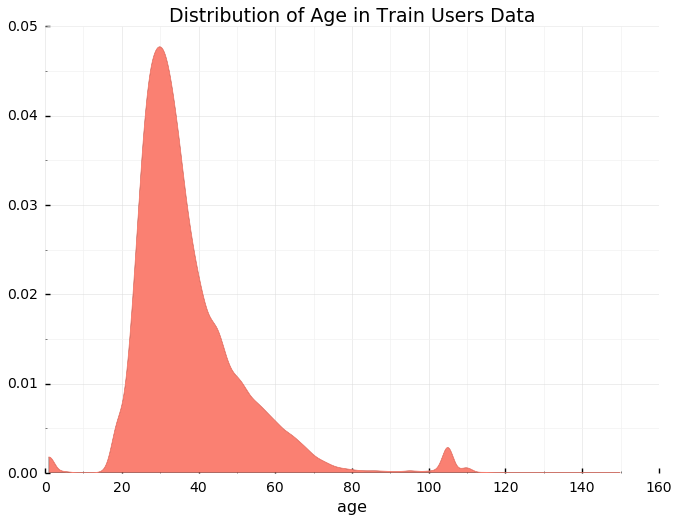

<ggplot: (8738000587221)>

In [33]:
# clean Train Users data set
users_train_ddf = hc.sql(
    "SELECT \
        %s \
    FROM \
        users_train"
    % cleaned_user_vars_to_select_str)\
    .cache()
users_train_ddf.registerTempTable('users_train')

print('Distribution of Age in Train Users Data:\n')
hc.sql(
    "SELECT \
        MIN(age) AS min_age, \
        MAX(age) AS max_age \
    FROM \
        users_train")\
    .show()

ggplot.ggplot(
        ggplot.aes(x='age'),
        data=users_train_ddf.select('age').toPandas()) + \
    ggplot.geom_density(
        color='salmon',
        fill='salmon') + \
    ggplot.ggtitle('Distribution of Age in Train Users Data') + \
    ggplot.theme_seaborn(
        style='whitegrid',   # whitegrid | darkgrid | nogrid | ticks
        context='talk',      # notebook | talk | paper | poster
        gridweight='light'   # extra heavy | heavy | medium | light
        )

Some quick take-aways and to-dos from the above findings:

- __`date_first_booking`__ is completely missing in the Test set; hence we can exclude it from modeling;

- __`first_browser`__ has way too many categories and is unlikely to be useful; we won't mess around with it either;

- __`signup_flow`__ and __`signup_method`__ have Test-set categories that are not present in the Train set; we'll have to be careful with such cases;

- for __`age`__:
    - there are erroneous values either below the allowed age of 18 or way beyond 100; let's impose cut-offs of 18 and 100 and rule out age values outside this range;  
    - for `NULL` and corrupt age values, let's naïvely impute them with the median of the "legitimate" age values in the Train set; it's probably possible to predict a User's age range from other variables, but let's take this simple approach for now;

- for categorical variables __`first_affiliate_tracked`__ and __`gender`__, let's also naïvely impute `NULL`s with a dummy category named `zzzUNKNOWN`; and

- for date and timestamp variables __`date_account_create`__ and __`timestamp_first_active`__, let's extract out the `year`, `month`, `day`, `day_of_week` and `hour_of_day` components, to be sure of capturing any minute signals contained in them.

In [34]:
min_age_cut_off = 18
max_age_cut_off = 100

median_age_for_imputation = \
    hc.sql(
        "SELECT \
            PERCENTILE_APPROX(age, 0.5) \
        FROM \
            users_train \
        WHERE \
            age BETWEEN %i AND %i"
        % (min_age_cut_off, max_age_cut_off))\
    .rdd.map(lambda row: row[0]).collect()[0]

print('Median Age for Imputation: %.1f years' % median_age_for_imputation)

Median Age for Imputation: 33.0 years


In [35]:
# note that in the below, some supposedly Integer variables are cast as Double
# because Spark ML requires that type for One-Hot Encoding
cleaned_and_imputed_user_vars_to_select_str = \
    "id, \
    date_account_created AS acct_crt_date, \
    YEAR(date_account_created) AS acct_crt_yr, \
    CAST(MONTH(date_account_created) AS DOUBLE) AS acct_crt_mth, \
    CAST(DAY(date_account_created) AS DOUBLE) AS acct_crt_day, \
    CAST(DATE_FORMAT(date_account_created, 'u') AS DOUBLE) AS acct_crt_day_of_wk_idx, \
    CONCAT(DATE_FORMAT(date_account_created, 'u'), ': ', \
           DATE_FORMAT(date_account_created, 'E')) AS acct_crt_day_of_wk, \
    timestamp_first_active AS fst_actv_ts, \
    YEAR(timestamp_first_active) AS fst_actv_yr, \
    CAST(MONTH(timestamp_first_active) AS DOUBLE) AS fst_actv_mth, \
    CAST(DAY(timestamp_first_active) AS DOUBLE) AS fst_actv_day, \
    CAST(FROM_UNIXTIME(CAST(timestamp_first_active AS BIGINT), 'u') AS DOUBLE) AS fst_activ_day_of_wk_idx, \
    CONCAT(FROM_UNIXTIME(CAST(timestamp_first_active AS BIGINT), 'u'), ': ', \
           FROM_UNIXTIME(CAST(timestamp_first_active AS BIGINT), 'E')) AS fst_actv_day_of_wk, \
    CAST(HOUR(timestamp_first_active) AS DOUBLE) + 1.0 AS fst_actv_hr, \
    CASE WHEN age BETWEEN %i AND %i THEN age \
         ELSE %f \
         END \
         AS age, \
    CASE WHEN gender IS NULL THEN 'zzzUNKNOWN' \
         ELSE gender \
         END \
         AS gender, \
    language, \
    signup_method, \
    signup_flow, \
    signup_app, \
    first_device_type, \
    affiliate_channel, \
    affiliate_provider, \
    CASE WHEN first_affiliate_tracked IS NULL THEN 'zzzUNKNOWN' \
         ELSE first_affiliate_tracked \
         END \
         AS first_affiliate_tracked, \
    country_destination, \
    train_valid_test" \
    % (min_age_cut_off, max_age_cut_off, median_age_for_imputation)

In [36]:
# impute missing values for Users data set
users_imputed_ddf = hc.sql(
    "SELECT \
        %s \
    FROM \
        users"
    % cleaned_and_imputed_user_vars_to_select_str)\
    .cache()
users_imputed_ddf.registerTempTable('users_imputed')

A quick check on the Users data we have thus far:

In [37]:
print('Cleaned & Imputed Users Data Thus Far:\n')
users_imputed_ddf.printSchema()

Cleaned & Imputed Users Data Thus Far:

root
 |-- id: string (nullable = true)
 |-- acct_crt_date: date (nullable = true)
 |-- acct_crt_yr: integer (nullable = true)
 |-- acct_crt_mth: double (nullable = true)
 |-- acct_crt_day: double (nullable = true)
 |-- acct_crt_day_of_wk_idx: double (nullable = true)
 |-- acct_crt_day_of_wk: string (nullable = true)
 |-- fst_actv_ts: timestamp (nullable = true)
 |-- fst_actv_yr: integer (nullable = true)
 |-- fst_actv_mth: double (nullable = true)
 |-- fst_actv_day: double (nullable = true)
 |-- fst_activ_day_of_wk_idx: double (nullable = true)
 |-- fst_actv_day_of_wk: string (nullable = true)
 |-- fst_actv_hr: double (nullable = true)
 |-- age: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- language: string (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: integer (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- affiliate_channel:

In [39]:
users_imputed_ddf\
    .select(
        'acct_crt_date',
        'acct_crt_yr',
        'acct_crt_mth',
        'acct_crt_day',
        'acct_crt_day_of_wk_idx',
        'acct_crt_day_of_wk')\
    .show(NB_EXAMPLES_TO_SHOW)

+-------------+-----------+------------+------------+----------------------+------------------+
|acct_crt_date|acct_crt_yr|acct_crt_mth|acct_crt_day|acct_crt_day_of_wk_idx|acct_crt_day_of_wk|
+-------------+-----------+------------+------------+----------------------+------------------+
|   2010-06-28|       2010|         6.0|        28.0|                   1.0|            1: Mon|
|   2011-05-25|       2011|         5.0|        25.0|                   3.0|            3: Wed|
|   2010-09-28|       2010|         9.0|        28.0|                   2.0|            2: Tue|
|   2011-12-05|       2011|        12.0|         5.0|                   1.0|            1: Mon|
|   2010-09-14|       2010|         9.0|        14.0|                   2.0|            2: Tue|
|   2010-01-01|       2010|         1.0|         1.0|                   5.0|            5: Fri|
|   2010-01-02|       2010|         1.0|         2.0|                   6.0|            6: Sat|
|   2010-01-03|       2010|         1.0|

In [40]:
users_imputed_ddf\
    .select(
        'fst_actv_ts',
        'fst_actv_yr',
        'fst_actv_mth',
        'fst_actv_day',
        'fst_activ_day_of_wk_idx',
        'fst_actv_day_of_wk',
        'fst_actv_hr')\
    .show(NB_EXAMPLES_TO_SHOW)

+--------------------+-----------+------------+------------+-----------------------+------------------+-----------+
|         fst_actv_ts|fst_actv_yr|fst_actv_mth|fst_actv_day|fst_activ_day_of_wk_idx|fst_actv_day_of_wk|fst_actv_hr|
+--------------------+-----------+------------+------------+-----------------------+------------------+-----------+
|2009-03-19 04:32:...|       2009|         3.0|        19.0|                    4.0|            4: Thu|        5.0|
|2009-05-23 17:48:...|       2009|         5.0|        23.0|                    6.0|            6: Sat|       18.0|
|2009-06-09 23:12:...|       2009|         6.0|         9.0|                    2.0|            2: Tue|       24.0|
|2009-10-31 06:01:...|       2009|        10.0|        31.0|                    6.0|            6: Sat|        7.0|
|2009-12-08 06:11:...|       2009|        12.0|         8.0|                    2.0|            2: Tue|        7.0|
|2010-01-01 21:56:...|       2010|         1.0|         1.0|            

In [41]:
users_imputed_ddf\
    .select(
        'age',
        'gender',
        'language',
        'signup_method',
        'signup_flow',
        'signup_app',
        'first_device_type')\
    .show(NB_EXAMPLES_TO_SHOW)

+---------+----------+--------+-------------+-----------+----------+-----------------+
|      age|    gender|language|signup_method|signup_flow|signup_app|first_device_type|
+---------+----------+--------+-------------+-----------+----------+-----------------+
|33.029926|zzzUNKNOWN|      EN|     facebook|          0|       Web|      Mac Desktop|
|     38.0|      male|      EN|     facebook|          0|       Web|      Mac Desktop|
|     56.0|    female|      EN|        basic|          3|       Web|  Windows Desktop|
|     42.0|    female|      EN|     facebook|          0|       Web|      Mac Desktop|
|     41.0|zzzUNKNOWN|      EN|        basic|          0|       Web|      Mac Desktop|
|33.029926|zzzUNKNOWN|      EN|        basic|          0|       Web|      Mac Desktop|
|     46.0|    female|      EN|        basic|          0|       Web|      Mac Desktop|
|     47.0|    female|      EN|        basic|          0|       Web|      Mac Desktop|
|     50.0|    female|      EN|        basi

In [24]:
SparkFiles.getRootDirectory()

!ls /private/var/folders/_r/pclm3n6x2b54y_1frhn2jh3c0000gn/T/spark-6efc845b-f57d-45bc-aadf-d28b90db2f09/userFiles-5b41fdd3-6a3f-4042-9172-71971ce201c5

MySQL-JDBC-5.1.38.jar          PostgreSQL-JDBC42-9.4.1207.jar PostgreSQL_JDBC42.jar


In [43]:
age_gender_year_destination_stats_ddf = hc.sql(
    "SELECT \
        age_bucket, \
        CASE WHEN age_bucket = '100+' THEN 99.5 \
             ELSE CAST(REGEXP_EXTRACT(age_bucket, '([0-9]*)-([0-9]*)', 1) AS DOUBLE) - 0.5 \
             END \
             AS age_from, \
        CASE WHEN age_bucket = '100+' THEN %i + 0.5 \
             ELSE CAST(REGEXP_EXTRACT(age_bucket, '([0-9]*)-([0-9]*)', 2) AS DOUBLE) + 0.5 \
             END \
             AS age_to, \
        gender, \
        country_destination, \
        year, \
        population_in_thousands \
    FROM \
        age_gender_year_destination_stats \
    ORDER BY \
        age_from, \
        gender, \
        country_destination, \
        year"
    % max_age_cut_off)\
    .cache()
age_gender_year_destination_stats_ddf.registerTempTable('age_gender_year_destination_stats')

age_gender_year_destination_stats_ddf.show(NB_EXAMPLES_TO_SHOW)

+----------+--------+------+------+-------------------+------+-----------------------+
|age_bucket|age_from|age_to|gender|country_destination|  year|population_in_thousands|
+----------+--------+------+------+-------------------+------+-----------------------+
|       0-4|    -0.5|   4.5|female|                 AU|2015.0|                  781.0|
|       0-4|    -0.5|   4.5|female|                 CA|2015.0|                  991.0|
|       0-4|    -0.5|   4.5|female|                 DE|2015.0|                 1713.0|
|       0-4|    -0.5|   4.5|female|                 ES|2015.0|                 1198.0|
|       0-4|    -0.5|   4.5|female|                 FR|2015.0|                 1938.0|
|       0-4|    -0.5|   4.5|female|                 GB|2015.0|                 1888.0|
|       0-4|    -0.5|   4.5|female|                 IT|2015.0|                 1383.0|
|       0-4|    -0.5|   4.5|female|                 NL|2015.0|                  438.0|
|       0-4|    -0.5|   4.5|female|        

In [50]:
age_buckets_ddf = hc.sql(
    "SELECT \
        DISTINCT \
            age_bucket, \
            age_from, \
            age_to \
    FROM \
        age_gender_year_destination_stats \
    ORDER BY \
        age_from")\
    .cache()
age_buckets_ddf.registerTempTable('age_buckets')

age_buckets_ddf.show(NB_EXAMPLES_TO_SHOW)

+----------+--------+------+
|age_bucket|age_from|age_to|
+----------+--------+------+
|       0-4|    -0.5|   4.5|
|       5-9|     4.5|   9.5|
|     10-14|     9.5|  14.5|
|     15-19|    14.5|  19.5|
|     20-24|    19.5|  24.5|
|     25-29|    24.5|  29.5|
|     30-34|    29.5|  34.5|
|     35-39|    34.5|  39.5|
|     40-44|    39.5|  44.5|
|     45-49|    44.5|  49.5|
|     50-54|    49.5|  54.5|
|     55-59|    54.5|  59.5|
|     60-64|    59.5|  64.5|
|     65-69|    64.5|  69.5|
|     70-74|    69.5|  74.5|
|     75-79|    74.5|  79.5|
|     80-84|    79.5|  84.5|
|     85-89|    84.5|  89.5|
|     90-94|    89.5|  94.5|
|     95-99|    94.5|  99.5|
|      100+|    99.5| 100.5|
+----------+--------+------+



In [85]:
# rename columns of Countries table to save space
countries_ddf = hc.sql(
    "SELECT \
        country_destination AS ctry, \
        lng_destination AS lon, \
        lat_destination AS lat, \
        distance_km AS dist, \
        destination_km2 AS area, \
        destination_language AS lang, \
        language_levenshtein_distance AS lang_dist \
    FROM \
        countries")\
    .cache()
countries_ddf.registerTempTable('countries')

countries_ddf.show()

+----+----------+----------+---------+---------+----+---------+
|ctry|       lon|       lat|     dist|     area|lang|lang_dist|
+----+----------+----------+---------+---------+----+---------+
|  AU| 133.27516|-26.853388|15297.744|7741220.0| eng|      0.0|
|  CA|-96.818146| 62.393303|2828.1333|9984670.0| eng|      0.0|
|  DE| 10.452764| 51.165707| 7879.568| 357022.0| deu|    72.61|
|  ES|-2.4876945| 39.896027| 7730.724| 505370.0| spa|    92.25|
|  FR|  2.209667| 46.232193| 7682.945| 643801.0| fra|    92.06|
|  GB|-3.4322774|  54.63322| 6883.659| 243610.0| eng|      0.0|
|  IT| 12.564167|  41.87399| 8636.631| 301340.0| ita|     89.4|
|  NL|   5.29525| 52.133057|7524.3203|  41543.0| nld|    63.22|
|  PT| -7.839319| 39.553444|7355.2534|  92090.0| por|    95.45|
|  US| -95.84403| 36.966427|      0.0|9826675.0| eng|      0.0|
+----+----------+----------+---------+---------+----+---------+



In [95]:
countries = \
    ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NL', 'PT', 'US']
country_attributes = \
    ['lon', 'lat', 'dist', 'area', 'lang', 'lang_dist']
country_features = \
    ['%s_%s' % (ctry, attr) for ctry, attr in itertools.product(countries, country_attributes)]
    
countries_features_ddf = hc.sql(
    "SELECT \
        %s \
    FROM \
        countries"
    % ', '.join("MAX(CASE WHEN ctry = '%s' THEN %s ELSE NULL END) AS %s"
                % (ctry, attr, '%s_%s' % (ctry, attr))
                for ctry, attr in itertools.product(countries, country_attributes)))\
    .cache()
countries_features_ddf.registerTempTable('countries_features')

countries_features_ddf.printSchema()

root
 |-- AU_lon: double (nullable = true)
 |-- AU_lat: double (nullable = true)
 |-- AU_dist: double (nullable = true)
 |-- AU_area: double (nullable = true)
 |-- AU_lang: string (nullable = true)
 |-- AU_lang_dist: double (nullable = true)
 |-- CA_lon: double (nullable = true)
 |-- CA_lat: double (nullable = true)
 |-- CA_dist: double (nullable = true)
 |-- CA_area: double (nullable = true)
 |-- CA_lang: string (nullable = true)
 |-- CA_lang_dist: double (nullable = true)
 |-- DE_lon: double (nullable = true)
 |-- DE_lat: double (nullable = true)
 |-- DE_dist: double (nullable = true)
 |-- DE_area: double (nullable = true)
 |-- DE_lang: string (nullable = true)
 |-- DE_lang_dist: double (nullable = true)
 |-- ES_lon: double (nullable = true)
 |-- ES_lat: double (nullable = true)
 |-- ES_dist: double (nullable = true)
 |-- ES_area: double (nullable = true)
 |-- ES_lang: string (nullable = true)
 |-- ES_lang_dist: double (nullable = true)
 |-- FR_lon: double (nullable = true)
 |-- FR_l

## Inspect Sessions Data

In [44]:
# do all Users have Sessions data?
users_session_summaries_ddf = hc.sql(
    "SELECT \
        users_imputed.id, \
        COUNT(*) > 0 AS has_sessions_data \
    FROM \
        users_imputed \
            LEFT JOIN sessions \
                ON users_imputed.id = sessions.user_id \
    GROUP BY \
        users_imputed.id")\
    .cache()
users_session_summaries_ddf.registerTempTable('users_session_summaries')

prop_users_with_sessions_data = \
    users_session_summaries_ddf\
    .select('has_sessions_data')\
    .rdd\
    .map(lambda row: row[0])\
    .sum() / (nb_users_train + nb_users_test)
print('%.1f%% of Users have sessions data'
      % (100 * prop_users_with_sessions_data))

100.0% of Users have sessions data


In [88]:
users_df.language.unique()

array([u'en', u'fr', u'de', u'es', u'it', u'pt', u'zh', u'ko', u'ja',
       u'ru', u'pl', u'el', u'sv', u'nl', u'hu', u'da', u'id', u'fi',
       u'no', u'tr', u'th', u'cs', u'hr', u'ca', u'is'], dtype=object)

In [90]:
help(users_df.join)

Help on method join in module pandas.core.frame:

join(self, other, on=None, how='left', lsuffix='', rsuffix='', sort=False) method of pandas.core.frame.DataFrame instance
    Join columns with other DataFrame either on index or on a key
    column. Efficiently Join multiple DataFrame objects by index at once by
    passing a list.
    
    Parameters
    ----------
    other : DataFrame, Series with name field set, or list of DataFrame
        Index should be similar to one of the columns in this one. If a
        Series is passed, its name attribute must be set, and that will be
        used as the column name in the resulting joined DataFrame
    on : column name, tuple/list of column names, or array-like
        Column(s) to use for joining, otherwise join on index. If multiples
        columns given, the passed DataFrame must have a MultiIndex. Can
        pass an array as the join key if not already contained in the
        calling DataFrame. Like an Excel VLOOKUP operation
    h

In [48]:
print("Non-NULL values of 'device_type' column: we'll need to convert '-unknown-' to NULL:\n")
hc.sql(
    "SELECT \
        DISTINCT(device_type) \
    FROM \
        sessions")\
    .show()

Non-NULL values of 'device_type' column: we'll need to convert '-unknown-' to NULL:

+--------------------+
|         device_type|
+--------------------+
|          Chromebook|
|     Windows Desktop|
|       Android Phone|
|           -unknown-|
|           iPodtouch|
|Android App Unkno...|
|       Windows Phone|
|         iPad Tablet|
|       Linux Desktop|
|              Tablet|
|              iPhone|
|          Blackberry|
|         Opera Phone|
|         Mac Desktop|
+--------------------+



Let's list out the relevant variables going into our model:

In [108]:
cat_y_var = 'country_destination'

numerical_x_vars = \
    ['age'] + countries_features_except_lang

indexed_cat_x_vars = \
    ['acct_crt_mth',
     'acct_crt_day',
     'acct_crt_day_of_wk_idx',
     'fst_actv_mth',
     'fst_actv_day',
     'fst_activ_day_of_wk_idx',
     'fst_actv_hr']
    
str_cat_x_vars = \
    ['acct_crt_yr',   # note that we'll treat this Int variable as String
     'fst_actv_yr',   # note that we'll treat this Int variable as String
     'age_bucket',
     'gender',
     'language',
     'signup_method',
     'signup_flow',   # note that we'll treat this Int variable as String
     'signup_app',
     'first_device_type',
     'affiliate_channel',
     'affiliate_provider',
     'first_affiliate_tracked']
    
original_cat_x_vars = indexed_cat_x_vars + str_cat_x_vars
original_x_vars = numerical_x_vars + original_cat_x_vars

In [109]:
select_str = ', '.join(original_x_vars)

nb_cats = hc.sql(
    "SELECT \
        %s \
    FROM \
        Xy"
    % ', '.join('COUNT(DISTINCT %s) AS %s' % (cat_x_var, cat_x_var)
                for cat_x_var in original_cat_x_vars))\
    .toPandas().T.iloc[:, 0]
nb_cats.name = 'nb_cats'

print('Numbers of Categories of Categorical Features: (totaling %i)' % nb_cats.sum())
nb_cats

Numbers of Categories of Categorical Features: (totaling 252)


acct_crt_mth               12
acct_crt_day               31
acct_crt_day_of_wk_idx      7
fst_actv_mth               12
fst_actv_day               31
fst_activ_day_of_wk_idx     7
fst_actv_hr                24
acct_crt_yr                 5
fst_actv_yr                 6
age_bucket                 18
gender                      4
language                   26
signup_method               4
signup_flow                18
signup_app                  4
first_device_type           9
affiliate_channel           8
affiliate_provider         18
first_affiliate_tracked     8
Name: nb_cats, dtype: int64

Now, we'll design Transformers to build a pipeline producing the numerical and one-hot-encoded features: